<a href="https://colab.research.google.com/github/DucDTran/redBus-hackathon/blob/main/redBus_Data_Decode_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade holidays
!pip install --q optuna
!pip install --q catboost
!pip install --q xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.74
    Uninstalling holidays-0.74:
      Successfully uninstalled holidays-0.74
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import holidays


pd.set_option('display.max_column', None)

In [3]:
# train_data_link = https://drive.google.com/file/d/1CKWt9sd4NuM5e3Skm2PxekTEu9e9Ioc7/view?usp=sharing
# test_data_link = https://drive.google.com/file/d/14KZmd-pfO2H3MeUCq_OmVu605_Ngdzos/view?usp=sharing
# transactions_data_link = https://drive.google.com/file/d/16HfxhGM9k_S1Y_kk1Bh0OXipNssnakVe/view?usp=sharing
!gdown 1CKWt9sd4NuM5e3Skm2PxekTEu9e9Ioc7
!gdown 14KZmd-pfO2H3MeUCq_OmVu605_Ngdzos
!gdown 16HfxhGM9k_S1Y_kk1Bh0OXipNssnakVe

Downloading...
From: https://drive.google.com/uc?id=1CKWt9sd4NuM5e3Skm2PxekTEu9e9Ioc7
To: /content/train.csv
100% 1.65M/1.65M [00:00<00:00, 30.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=14KZmd-pfO2H3MeUCq_OmVu605_Ngdzos
To: /content/test.csv
100% 198k/198k [00:00<00:00, 12.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16HfxhGM9k_S1Y_kk1Bh0OXipNssnakVe
From (redirected): https://drive.google.com/uc?id=16HfxhGM9k_S1Y_kk1Bh0OXipNssnakVe&confirm=t&uuid=313a33a6-f383-4ee6-97e0-0651bccd2047
To: /content/transactions.csv
100% 186M/186M [00:02<00:00, 81.5MB/s]


In [4]:
transactions_data = pd.read_csv('transactions.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
transactions_data['doj'] = pd.to_datetime(transactions_data['doj'])
transactions_data['doi'] = pd.to_datetime(transactions_data['doi'])

train_data['doj'] = pd.to_datetime(train_data['doj'])
test_data['doj'] = pd.to_datetime(test_data['doj'])

In [6]:
### 7 DAYS
snapshot_dbd_15 = transactions_data[transactions_data['dbd'] == 15]
snapshot_dbd_22 = transactions_data[transactions_data['dbd'] == 22]

merged_snapshots = pd.merge(
    snapshot_dbd_15,
    snapshot_dbd_22,
    on=['doj', 'srcid', 'destid'],
    suffixes=('', '_22')
)

merged_snapshots['seats_booked_7_days_previous'] = (
    merged_snapshots['cumsum_seatcount'] - merged_snapshots['cumsum_seatcount_22']
)
merged_snapshots['seats_searched_7_days_previous'] = (
    merged_snapshots['cumsum_searchcount'] - merged_snapshots['cumsum_searchcount_22']
)

In [7]:
train_df = pd.merge(train_data, merged_snapshots, on=['doj', 'srcid', 'destid'], how='left')
test_df = pd.merge(test_data, merged_snapshots, on=['doj', 'srcid', 'destid'], how='left')

### Date-based Features

In [8]:
def add_date_features(df):
    temp_df = df.copy()
    temp_df['doj_day_of_month'] = temp_df['doj'].dt.day
    temp_df['doj_day_of_week'] = temp_df['doj'].dt.dayofweek
    temp_df['doj_month'] = temp_df['doj'].dt.month
    temp_df['doj_year'] = temp_df['doj'].dt.year
    temp_df['doj_week_of_year'] = temp_df['doj'].dt.isocalendar().week
    temp_df['doj_is_weekend'] = (temp_df['doj_day_of_week'] >= 5).astype(int)
    return temp_df

In [9]:

min_date = min(train_df['doj'].min(), test_df['doj'].min())
max_date = max(train_df['doj'].max(), test_df['doj'].max())
years = range(min_date.year, max_date.year)
holiday_dates = holidays.IN(years=years)

In [10]:
holiday_dates

{datetime.date(2024, 1, 26): 'Republic Day', datetime.date(2024, 8, 15): 'Independence Day', datetime.date(2024, 10, 2): 'Gandhi Jayanti', datetime.date(2024, 5, 23): 'Buddha Purnima', datetime.date(2024, 10, 31): 'Diwali', datetime.date(2024, 8, 26): 'Janmashtami', datetime.date(2024, 10, 12): 'Dussehra', datetime.date(2024, 4, 21): 'Mahavir Jayanti', datetime.date(2024, 3, 8): 'Maha Shivaratri', datetime.date(2024, 11, 15): 'Guru Nanak Jayanti', datetime.date(2024, 7, 17): 'Ashura', datetime.date(2024, 9, 16): "Prophet's Birthday", datetime.date(2024, 4, 11): 'Eid al-Fitr', datetime.date(2024, 6, 17): 'Eid al-Adha', datetime.date(2024, 3, 29): 'Good Friday', datetime.date(2024, 12, 25): 'Christmas', datetime.date(2023, 1, 26): 'Republic Day', datetime.date(2023, 8, 15): 'Independence Day', datetime.date(2023, 10, 2): 'Gandhi Jayanti', datetime.date(2023, 5, 5): 'Buddha Purnima', datetime.date(2023, 11, 12): 'Diwali', datetime.date(2023, 9, 7): 'Janmashtami', datetime.date(2023, 10, 2

In [11]:
def add_event_features(df):
    temp_df = df.copy()
    ### Feature 1: Is the Journey a Holiday?
    temp_df['doj_is_holday'] = temp_df['doj'].isin(holiday_dates).astype(int)

    ### Feature 2: Is the Journey Part of a Long Weekend? ===
    def is_long_weekend(date):
        # Friday before a Monday holiday
        if date.weekday() == 4 and (date + pd.Timedelta(days=3)) in holiday_dates:
            return 1
        # Monday after a Friday holiday
        if date.weekday() == 0 and (date - pd.Timedelta(days=3)) in holiday_dates:
            return 1
        # Day before a holiday (e.g., travel on Thursday for a Friday holiday)
        if (date + pd.Timedelta(days=1)) in holiday_dates:
            return 1
        # Day after a holiday (e.g., travel back on Tuesday for a Monday holiday)
        if (date - pd.Timedelta(days=1)) in holiday_dates:
            return 1
        return 0
    temp_df['doj_is_long_weekend'] = temp_df['doj'].apply(is_long_weekend)

    ### Feature 3: Days to the Next Holiday ===
    # This captures the urgency of travel as a holiday approaches.
    # Note: This can be computationally slow. A simpler version is shown here.
    sorted_holidays = sorted(list(holiday_dates))

    def days_to_next_holiday(date):
        # Find the first holiday that comes after the journey date
        future_holidays = [h for h in sorted_holidays if h > date.date()]
        if future_holidays:
            return (future_holidays[0] - date.date()).days
        return 365 # Return a large number if no future holidays are found

    # Applying this can be slow; for a hackathon, you might pre-calculate this for all dates.
    temp_df['doj_close_to_holiday'] = temp_df['doj'].apply(days_to_next_holiday)

    ### Feature 4: Custom Events (School Vacations, Wedding Season) ===
    # These are based on domain knowledge.
    def get_season(date):
        month = date.month
        if month in [5, 6]:  # May, June
            return 'Summer_Vacation'
        if month in [11, 12, 1]:  # Nov, Dec, Jan
            return 'Peak_Wedding_Season'
        if month in [10]: # October
             return 'Diwali_Season'
        return 'Off_Season'

    temp_df['doj_custom_events'] = temp_df['doj'].apply(get_season)

    return temp_df

In [12]:
def add_behavioral_features(df):
    temp_df = df.copy()
    temp_df['search_to_book_ratio'] = temp_df['cumsum_seatcount'] / (temp_df['cumsum_searchcount'] + 0.0001)
    return temp_df

In [13]:
from sklearn.preprocessing import LabelEncoder
import re

def encode_categorical_features(df):
    temp_df = df.copy()
    le = LabelEncoder()
    temp_df['doj_custom_events_transformed'] = le.fit_transform(temp_df['doj_custom_events'])
    temp_df['srcid_tier'] = temp_df['srcid_tier'].apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else x)
    temp_df['destid_tier'] = temp_df['destid_tier'].apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else x)

    return temp_df

In [14]:
processed_train_data = train_df.copy()
processed_test_data = test_df.copy()

processed_train_data = add_date_features(processed_train_data)
processed_train_data = add_event_features(processed_train_data)
processed_train_data = add_behavioral_features(processed_train_data)
processed_train_data = encode_categorical_features(processed_train_data)

processed_test_data = add_date_features(processed_test_data)
processed_test_data = add_event_features(processed_test_data)
processed_test_data = add_behavioral_features(processed_test_data)
processed_test_data = encode_categorical_features(processed_test_data)

/tmp/ipython-input-11-2629899967.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  temp_df['doj_is_holday'] = temp_df['doj'].isin(holiday_dates).astype(int)
/tmp/ipython-input-11-2629899967.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  temp_df['doj_is_holday'] = temp_df['doj'].isin(holiday_dates).astype(int)


In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import optuna

processed_train_data['route'] = processed_train_data['srcid'].astype(str) + '-' + processed_train_data['destid'].astype(str)
features = ['srcid', 'destid', 'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount', 'search_to_book_ratio',
            'doj_day_of_month', 'doj_month', 'doj_is_weekend', 'doj_is_holday', 'doj_close_to_holiday', 'doj_custom_events_transformed',
            'seats_booked_7_days_previous', 'seats_searched_7_days_previous']
target = 'final_seatcount'

def objective_lgbm(trial):
    # Define the hyperparameter search space for this trial
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(processed_train_data):

        train_fold_df = processed_train_data.iloc[train_index].copy()
        val_fold_df = processed_train_data.iloc[val_index].copy()

        ### Create Route Average Demand
        route_demand_summary_overall = train_fold_df.groupby('route')[target].mean().rename('route_avg_demand_overall').reset_index()

        # Calculate rolling features of Route Average Demand
        train_fold_df.set_index('doj', inplace=True)
        train_fold_df = train_fold_df.assign(
            route_avg_demand_last_3m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('90D').mean()),
            route_avg_demand_last_6m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('180D').mean()),
            route_avg_demand_last_9m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('270D').mean())
        )

        # Bring 'doj' back to being a regular column
        train_fold_df.reset_index(inplace=True)

        # Create momentum feature
        epsilon = 1e-6 # To avoid division by zero
        train_fold_df['momentum_3m_vs_6m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_6m'] + epsilon)
        train_fold_df['momentum_6m_vs_9m'] = train_fold_df['route_avg_demand_last_6m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)
        train_fold_df['momentum_3m_vs_9m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)

        train_fold_df = pd.merge(train_fold_df, route_demand_summary_overall, on='route', how='left')
        val_fold_df = pd.merge(val_fold_df, route_demand_summary_overall, on='route', how='left')

        # For rolling features, get the LAST calculated value for each route from the training data
        last_known_rolling_vals = train_fold_df.sort_values('doj').groupby('route').last()[[
            'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
            'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m'
        ]]
        val_fold_df = pd.merge(val_fold_df, last_known_rolling_vals, on='route', how='left')

        # Create Global Average Demand
        global_avg_demand = train_fold_df[target].mean()
        # Columns to fill with the global average
        fill_avg_cols = ['route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
                         'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
        for col in fill_avg_cols:
            train_fold_df.fillna({col: global_avg_demand}, inplace=True)
            val_fold_df.fillna({col: global_avg_demand}, inplace=True)

        # For ratios, a neutral value is 1 (indicating no change)
        train_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

        val_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)


        # Create Final Train and Validation Dataframe
        train_fold_final = train_fold_df.copy()
        val_fold_final = val_fold_df.copy()

        features_all = features + ['route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
                                   'momentum_3m_vs_9m', 'momentum_6m_vs_9m', 'momentum_3m_vs_6m']
        X_train = train_fold_final[features_all]
        y_train = train_fold_final[target]
        X_val = val_fold_final[features_all]
        y_val = val_fold_final[target]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    # Return the average score for this set of hyperparameters
    return np.mean(rmse_scores)



study_lgbm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True) # Run 50-100 trials

print("Number of finished trials: ", len(study_lgbm.trials))
print("Best trial:")
best_trial_lgbm = study_lgbm.best_trial

print("  Value (RMSE): ", best_trial_lgbm.value)
print("  Params: ")
for key, value in best_trial_lgbm.params.items():
    print(f"    {key}: {value}")

best_params_lgbm = study_lgbm.best_params

[I 2025-06-22 08:22:05,489] A new study created in memory with name: no-name-72fc9f12-f472-4f74-89c5-d97d1fb9dfc2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-22 08:22:36,374] Trial 0 finished with value: 619.8002330876506 and parameters: {'n_estimators': 800, 'learning_rate': 0.2536999076681772, 'num_leaves': 372, 'max_depth': 8, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.5779972601681014, 'bagging_freq': 1, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'min_child_samples': 72}. Best is trial 0 with value: 619.8002330876506.
[I 2025-06-22 08:22:42,406] Trial 1 finished with value: 593.3152719387047 and parameters: {'n_estimators': 100, 'learning_rate': 0.2708160864249968, 'num_leaves': 420, 'max_depth': 5, 'feature_fraction': 0.5909124836035503, 'bagging_fraction': 0.5917022549267169, 'bagging_freq': 3, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'min_child_samples': 32}. Best is trial 1 with value: 593.3152719387047.
[I 2025-06-22 08:23:39,337] Trial 2 finished with value: 572.8002857005093 and parameters: {'n_estimators': 1300, 'learning_rate': 0.01607123851203

In [18]:
final_train_df = processed_train_data.sort_values('doj').copy()
print("Creating final features on the entire training dataset...")
final_train_df['route'] = final_train_df['srcid'].astype(str) + '-' + final_train_df['destid'].astype(str)
features = ['srcid', 'destid', 'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount', 'seats_booked_7_days_previous',
            'seats_searched_7_days_previous', 'search_to_book_ratio', 'doj_day_of_month', 'doj_day_of_week',
            'doj_month', 'doj_week_of_year', 'doj_is_weekend', 'doj_is_holday', 'doj_close_to_holiday', 'doj_custom_events_transformed']
target = 'final_seatcount'

route_demand_summary = final_train_df.groupby('route')[target].mean().rename('route_avg_demand_overall')
final_train_df = pd.merge(final_train_df, route_demand_summary, on='route', how='left')

final_train_df.set_index('doj', inplace=True)
final_train_df = final_train_df.assign(
    route_avg_demand_last_3m = final_train_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('90D').mean()),
    route_avg_demand_last_6m = final_train_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('180D').mean()),
    route_avg_demand_last_9m = final_train_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('270D').mean())
)
final_train_df.reset_index(inplace=True)

epsilon = 1e-6
final_train_df['momentum_3m_vs_9m'] = final_train_df['route_avg_demand_last_3m'] / (final_train_df['route_avg_demand_last_9m'] + epsilon)
final_train_df['momentum_3m_vs_6m'] = final_train_df['route_avg_demand_last_3m'] / (final_train_df['route_avg_demand_last_6m'] + epsilon)
final_train_df['momentum_6m_vs_9m'] = final_train_df['route_avg_demand_last_6m'] / (final_train_df['route_avg_demand_last_9m'] + epsilon)

global_avg_demand = final_train_df[target].mean()
fill_avg_cols = ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m']
for col in fill_avg_cols:
    final_train_df.fillna({col: global_avg_demand}, inplace=True)

# For ratios, a neutral value is 1 (indicating no change)
final_train_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
final_train_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
final_train_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

print("Final feature-rich training data is ready.")

Creating final features on the entire training dataset...
Final feature-rich training data is ready.


In [19]:
# Define the full list of features used
features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
X_train_final = final_train_df[features_all]
y_train_final = final_train_df[target]

# Train the final model using ALL the data and best_params
final_model_lgbm = lgb.LGBMRegressor(**best_params_lgbm)
final_model_lgbm.fit(X_train_final, y_train_final)

print("Final LightGBM model trained on all data with all features.")

Final LightGBM model trained on all data with all features.


In [20]:
train_raw_df = pd.read_csv('train.csv')
test_raw_df = pd.read_csv('test.csv')

train_raw_df['is_train'] = 1
test_raw_df['is_train'] = 0

combined_df = pd.concat([train_raw_df, test_raw_df], sort=False)

# 1. Basic Features (Date parts, momentum, etc.)
combined_df['doj'] = pd.to_datetime(combined_df['doj'])
combined_df['route'] = combined_df['srcid'].astype(str) + '_' + combined_df['destid'].astype(str)
combined_df = pd.merge(combined_df, merged_snapshots, on=['doj', 'srcid', 'destid'], how='left')

combined_df = add_date_features(combined_df)
combined_df = add_event_features(combined_df)
combined_df = add_behavioral_features(combined_df)
combined_df = encode_categorical_features(combined_df)

# 2. Rolling Window & Momentum Ratio Features
combined_df.sort_values(['route', 'doj'], inplace=True)

route_demand_summary = combined_df.groupby('route')[target].mean().rename('route_avg_demand_overall')
combined_df = pd.merge(combined_df, route_demand_summary, on='route', how='left')

# Set index for time-based rolling
combined_df.set_index('doj', inplace=True)

# Calculate rolling features. The .shift(1) ensures that for any row, the calculation
# only uses data from rows before it. This automatically prevents test data from
# using its own future information and makes it use training data correctly.
combined_df = combined_df.assign(
    route_avg_demand_last_3m = combined_df.groupby('route')['final_seatcount'].transform(lambda x: x.shift(1).rolling('90D').mean()),
    route_avg_demand_last_6m = combined_df.groupby('route')['final_seatcount'].transform(lambda x: x.shift(1).rolling('180D').mean()),
    route_avg_demand_last_9m = combined_df.groupby('route')['final_seatcount'].transform(lambda x: x.shift(1).rolling('270D').mean())
)
combined_df.reset_index(inplace=True)

# Calculate ratio and handle NaNs
epsilon = 1e-6
combined_df['momentum_3m_vs_9m'] = combined_df['route_avg_demand_last_3m'] / (combined_df['route_avg_demand_last_9m'] + epsilon)
combined_df['momentum_3m_vs_6m'] = combined_df['route_avg_demand_last_3m'] / (combined_df['route_avg_demand_last_6m'] + epsilon)
combined_df['momentum_6m_vs_9m'] = combined_df['route_avg_demand_last_6m'] / (combined_df['route_avg_demand_last_9m'] + epsilon)

combined_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
combined_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
combined_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

# Handle other NaNs created by rolling windows (e.g., for early data points)
global_avg_demand_all_data = combined_df['final_seatcount'].mean() # Use mean from all training data
combined_df.fillna({'route_avg_demand_last_3m': global_avg_demand_all_data}, inplace=True)
combined_df.fillna({'route_avg_demand_last_6m': global_avg_demand_all_data}, inplace=True)
combined_df.fillna({'route_avg_demand_last_9m': global_avg_demand_all_data}, inplace=True)

# --- Split back into final Train and Test sets ---
test_final = combined_df[combined_df['is_train'] == 0].copy()

# Ensure the final test set has the exact feature columns your model was trained on
X_test = test_final[features_all]

/tmp/ipython-input-11-2629899967.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  temp_df['doj_is_holday'] = temp_df['doj'].isin(holiday_dates).astype(int)


In [21]:
print("Making predictions with final models...")
lgb_preds = final_model_lgbm.predict(X_test)

Making predictions with final models...


In [22]:
test_final['lgb_preds'] = lgb_preds
test_final.head()

,doj,srcid,destid,final_seatcount,is_train,route_key,route,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,doi_22,srcid_region_22,destid_region_22,srcid_tier_22,destid_tier_22,cumsum_seatcount_22,cumsum_searchcount_22,dbd_22,seats_booked_7_days_previous,seats_searched_7_days_previous,doj_day_of_month,doj_day_of_week,doj_month,doj_year,doj_week_of_year,doj_is_weekend,doj_is_holday,doj_is_long_weekend,doj_close_to_holiday,doj_custom_events,search_to_book_ratio,doj_custom_events_transformed,route_avg_demand_overall,route_avg_demand_last_3m,route_avg_demand_last_6m,route_avg_demand_last_9m,momentum_3m_vs_9m,momentum_3m_vs_6m,momentum_6m_vs_9m,lgb_preds
672,2025-01-01,11,36,NaN,0,2025-01-01_11_36,11_36,2024-12-17,Rest of North,Delhi,1,2,32.0,1160.0,15,2024-12-10,Rest of North,Delhi,Tier 1,Tier2,28.0,628.0,22,4.0,532.0,1,2,1,2025,1,0,0,0,25,Peak_Wedding_Season,0.027586,2,2083.333333,2900.222222,2552.000000,2432.488889,1.192286,1.136451,1.049131,2243.067474
673,2025-01-02,11,36,NaN,0,2025-01-02_11_36,11_36,2024-12-18,Rest of North,Delhi,1,2,4.0,644.0,15,2024-12-11,Rest of North,Delhi,Tier 1,Tier2,0.0,428.0,22,4.0,216.0,2,3,1,2025,1,0,0,0,24,Peak_Wedding_Season,0.006211,2,2083.333333,2915.865169,2554.033520,2435.137546,1.197413,1.141671,1.048825,2108.659721
674,2025-01-03,11,36,NaN,0,2025-01-03_11_36,11_36,2024-12-19,Rest of North,Delhi,1,2,0.0,544.0,15,2024-12-12,Rest of North,Delhi,Tier 1,Tier2,0.0,336.0,22,0.0,208.0,3,4,1,2025,1,0,0,0,23,Peak_Wedding_Season,0.000000,2,2083.333333,2929.454545,2555.438202,2435.656716,1.202737,1.146361,1.049178,2302.089873
675,2025-01-04,11,36,NaN,0,2025-01-04_11_36,11_36,2024-12-20,Rest of North,Delhi,1,2,4.0,644.0,15,2024-12-13,Rest of North,Delhi,Tier 1,Tier2,4.0,380.0,22,0.0,264.0,4,5,1,2025,1,1,0,0,22,Peak_Wedding_Season,0.006211,2,2083.333333,2942.666667,2552.248588,2439.191011,1.206411,1.152970,1.046350,2383.977994
676,2025-01-05,11,36,NaN,0,2025-01-05_11_36,11_36,2024-12-21,Rest of North,Delhi,1,2,8.0,1348.0,15,2024-12-14,Rest of North,Delhi,Tier 1,Tier2,4.0,384.0,22,4.0,964.0,5,6,1,2025,1,1,0,0,21,Peak_Wedding_Season,0.005935,2,2083.333333,2938.372093,2553.522727,2444.962406,1.201807,1.150713,1.044402,3195.963008


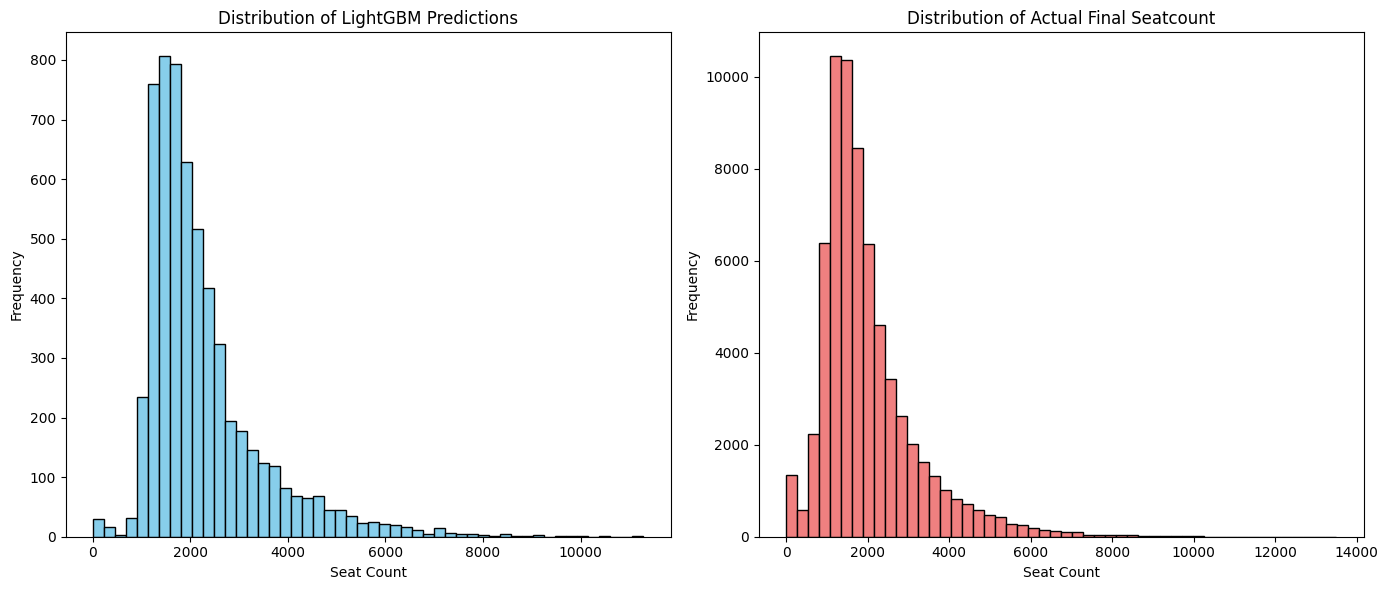

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a figure with 2 subplots (1 row, 2 columns)

lgb_preds_series = pd.Series(lgb_preds)

# Plot histogram for predictions on the first subplot
lgb_preds_series.plot.hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of LightGBM Predictions')
axes[0].set_xlabel('Seat Count')
axes[0].set_ylabel('Frequency')

# Plot histogram for actual values on the second subplot
processed_train_data['final_seatcount'].plot.hist(ax=axes[1], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Actual Final Seatcount')
axes[1].set_xlabel('Seat Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [24]:
def objective_xgb(trial):
    # Define the hyperparameter search space for this trial
    params = {
        'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 42, 'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(processed_train_data):


        train_fold_df = processed_train_data.iloc[train_index].copy()
        val_fold_df = processed_train_data.iloc[val_index].copy()

        ### Create Route Average Demand
        route_demand_summary_overall = train_fold_df.groupby('route')[target].mean().rename('route_avg_demand_overall').reset_index()

        # Calculate rolling features of Route Average Demand
        train_fold_df.set_index('doj', inplace=True)
        train_fold_df = train_fold_df.assign(
            route_avg_demand_last_3m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('90D').mean()),
            route_avg_demand_last_6m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('180D').mean()),
            route_avg_demand_last_9m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('270D').mean())
        )

        # Bring 'doj' back to being a regular column
        train_fold_df.reset_index(inplace=True)

        # Create momentum feature
        epsilon = 1e-6 # To avoid division by zero
        train_fold_df['momentum_3m_vs_6m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_6m'] + epsilon)
        train_fold_df['momentum_6m_vs_9m'] = train_fold_df['route_avg_demand_last_6m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)
        train_fold_df['momentum_3m_vs_9m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)

        train_fold_df = pd.merge(train_fold_df, route_demand_summary_overall, on='route', how='left')
        val_fold_df = pd.merge(val_fold_df, route_demand_summary_overall, on='route', how='left')

        # For rolling features, get the LAST calculated value for each route from the training data
        last_known_rolling_vals = train_fold_df.sort_values('doj').groupby('route').last()[[
            'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m'
        ]]
        val_fold_df = pd.merge(val_fold_df, last_known_rolling_vals, on='route', how='left')

        # Create Global Average Demand
        global_avg_demand = train_fold_df[target].mean()
        # Columns to fill with the global average
        fill_avg_cols = ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m']
        for col in fill_avg_cols:
            train_fold_df.fillna({col: global_avg_demand}, inplace=True)
            val_fold_df.fillna({col: global_avg_demand}, inplace=True)

        # For ratios, a neutral value is 1 (indicating no change)
        train_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

        val_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)


        # Create Final Train and Validation Dataframe
        train_fold_final = train_fold_df.copy()
        val_fold_final = val_fold_df.copy()

        features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
        X_train = train_fold_final[features_all]
        y_train = train_fold_final[target]
        X_val = val_fold_final[features_all]
        y_val = val_fold_final[target]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    # Return the average score for this set of hyperparameters
    return np.mean(rmse_scores)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True) # Run 50-100 trials

print("Number of finished trials: ", len(study_xgb.trials))
print("Best trial:")
best_trial_xgb = study_xgb.best_trial

print("  Value (RMSE): ", best_trial_xgb.value)
print("  Params: ")
for key, value in best_trial_xgb.params.items():
    print(f"    {key}: {value}")

best_params_xgb = study_xgb.best_params

[I 2025-06-22 08:59:45,050] A new study created in memory with name: no-name-48f0b594-d70f-4973-a9ba-616651b53989


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-22 09:00:08,269] Trial 0 finished with value: 549.0884614543089 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.0357456806807835, 'subsample': 0.6791678863867409, 'colsample_bytree': 0.9767058006258119, 'reg_alpha': 0.0023891401551429945, 'reg_lambda': 0.00015261468958912042, 'min_child_weight': 7}. Best is trial 0 with value: 549.0884614543089.
[I 2025-06-22 09:01:40,646] Trial 1 finished with value: 555.9452704701802 and parameters: {'n_estimators': 800, 'max_depth': 11, 'learning_rate': 0.03975015748413167, 'subsample': 0.8691772508016974, 'colsample_bytree': 0.7945614602403228, 'reg_alpha': 2.1043041345700164, 'reg_lambda': 0.0008078786522493683, 'min_child_weight': 10}. Best is trial 0 with value: 549.0884614543089.
[I 2025-06-22 09:02:41,874] Trial 2 finished with value: 587.6870368161672 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.010561371640281989, 'subsample': 0.8059114935593897, 'colsample_bytree': 0.887182763

In [25]:
print(best_trial_xgb)
print(best_params_xgb)

FrozenTrial(number=39, state=1, values=[541.1602006215268], datetime_start=datetime.datetime(2025, 6, 22, 9, 27, 29, 276444), datetime_complete=datetime.datetime(2025, 6, 22, 9, 28, 26, 406650), params={'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.0171011609364415, 'subsample': 0.6952254883495613, 'colsample_bytree': 0.8092218506453641, 'reg_alpha': 1.5865742078763079, 'reg_lambda': 3.891115426128105e-08, 'min_child_weight': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=50), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'reg_lambda': FloatDistribution(high=10.0,

In [26]:
# best_trial_xgb = 534.326564436688
# best_params_xgb = {'learning_rate': 0.015475572663052788, 'n_estimators': 1098, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 1.1287014940125648, 'subsample': 0.7988314904538745, 'colsample_bytree': 0.6024005327324712, 'reg_alpha': 4.474455545149513, 'reg_lambda': 3.128263120199872}

In [27]:
# Define the full list of features used
features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
                           'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
X_train_final = final_train_df[features_all]
y_train_final = final_train_df[target]

# Train the final model using ALL the data and best_params
final_model_xgb = xgb.XGBRegressor(**best_params_xgb)
final_model_xgb.fit(X_train_final, y_train_final)

print("Final XGB model trained on all data with all features.")

Final XGB model trained on all data with all features.


Making predictions with final models...


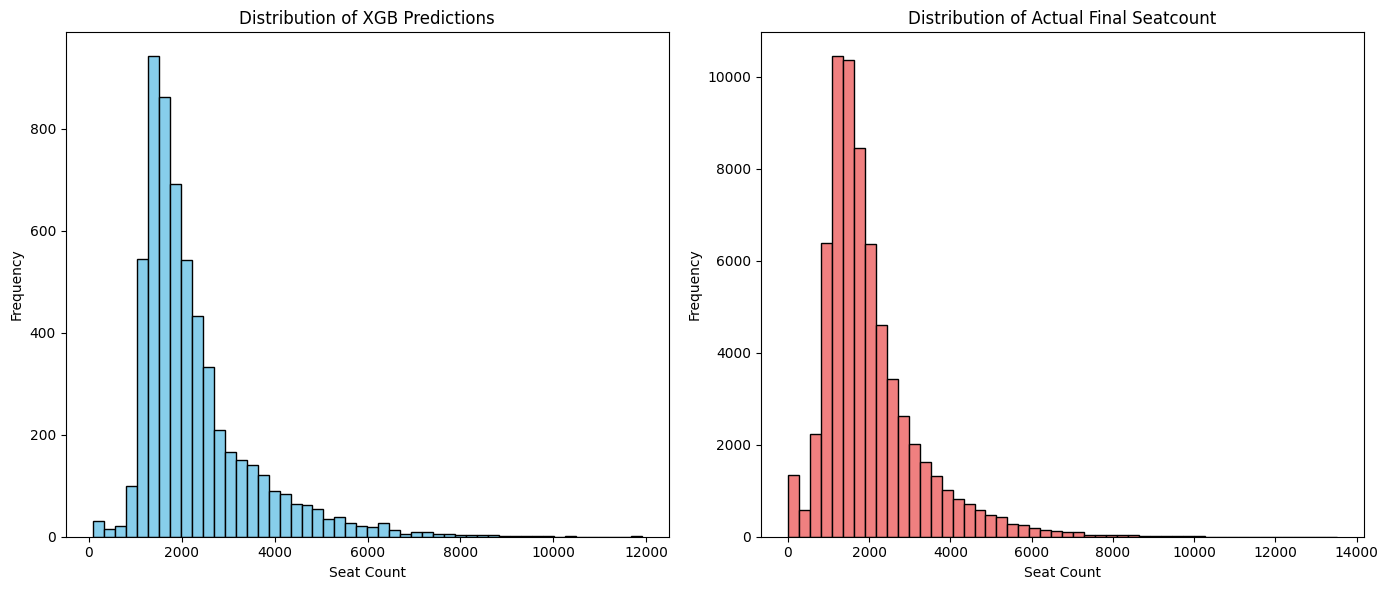

In [28]:
print("Making predictions with final models...")
xgb_preds = final_model_xgb.predict(X_test)

test_final['xgb_preds'] = xgb_preds

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a figure with 2 subplots (1 row, 2 columns)

xgb_preds_series = pd.Series(xgb_preds)

# Plot histogram for predictions on the first subplot
xgb_preds_series.plot.hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of XGB Predictions')
axes[0].set_xlabel('Seat Count')
axes[0].set_ylabel('Frequency')

# Plot histogram for actual values on the second subplot
processed_train_data['final_seatcount'].plot.hist(ax=axes[1], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Actual Final Seatcount')
axes[1].set_xlabel('Seat Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [29]:
from sklearn.ensemble import RandomForestRegressor

def objective_rf(trial):
    # Define the hyperparameter search space for this trial
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, 30, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(processed_train_data):


        train_fold_df = processed_train_data.iloc[train_index].copy()
        val_fold_df = processed_train_data.iloc[val_index].copy()

        ### Create Route Average Demand
        route_demand_summary_overall = train_fold_df.groupby('route')[target].mean().rename('route_avg_demand_overall').reset_index()

        # Calculate rolling features of Route Average Demand
        train_fold_df.set_index('doj', inplace=True)
        train_fold_df = train_fold_df.assign(
            route_avg_demand_last_3m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('90D').mean()),
            route_avg_demand_last_6m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('180D').mean()),
            route_avg_demand_last_9m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('270D').mean())
        )

        # Bring 'doj' back to being a regular column
        train_fold_df.reset_index(inplace=True)

        # Create momentum feature
        epsilon = 1e-6 # To avoid division by zero
        train_fold_df['momentum_3m_vs_6m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_6m'] + epsilon)
        train_fold_df['momentum_6m_vs_9m'] = train_fold_df['route_avg_demand_last_6m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)
        train_fold_df['momentum_3m_vs_9m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)

        train_fold_df = pd.merge(train_fold_df, route_demand_summary_overall, on='route', how='left')
        val_fold_df = pd.merge(val_fold_df, route_demand_summary_overall, on='route', how='left')

        # For rolling features, get the LAST calculated value for each route from the training data
        last_known_rolling_vals = train_fold_df.sort_values('doj').groupby('route').last()[[
            'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m'
        ]]
        val_fold_df = pd.merge(val_fold_df, last_known_rolling_vals, on='route', how='left')

        # Create Global Average Demand
        global_avg_demand = train_fold_df[target].mean()
        # Columns to fill with the global average
        fill_avg_cols = ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m']
        for col in fill_avg_cols:
            train_fold_df.fillna({col: global_avg_demand}, inplace=True)
            val_fold_df.fillna({col: global_avg_demand}, inplace=True)

        # For ratios, a neutral value is 1 (indicating no change)
        train_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

        val_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)


        # Create Final Train and Validation Dataframe
        train_fold_final = train_fold_df.copy()
        val_fold_final = val_fold_df.copy()

        features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
        X_train = train_fold_final[features_all]
        y_train = train_fold_final[target]
        X_val = val_fold_final[features_all]
        y_val = val_fold_final[target]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    # Return the average score for this set of hyperparameters
    return np.mean(rmse_scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True) # Run 50-100 trials

print("Number of finished trials: ", len(study_rf.trials))
print("Best trial:")
best_trial_rf = study_rf.best_trial

print("  Value (RMSE): ", best_trial_rf.value)
print("  Params: ")
for key, value in best_trial_rf.params.items():
    print(f"    {key}: {value}")

best_params_rf = study_rf.best_params

[I 2025-06-22 09:40:12,935] A new study created in memory with name: no-name-7fa8e9ac-4765-4103-9f9b-06db2b6b17f0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-22 09:41:18,906] Trial 0 finished with value: 591.5004874987122 and parameters: {'n_estimators': 169, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 591.5004874987122.
[I 2025-06-22 09:42:04,278] Trial 1 finished with value: 596.8578984635238 and parameters: {'n_estimators': 126, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 591.5004874987122.
[I 2025-06-22 09:42:23,656] Trial 2 finished with value: 668.6098897708532 and parameters: {'n_estimators': 128, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 591.5004874987122.
[I 2025-06-22 09:45:33,068] Trial 3 finished with value: 598.1306416589389 and parameters: {'n_estimators': 101, 'max_depth': None, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 591.5004874987122.


Final RF model trained on all data with all features.
Making predictions with final models...


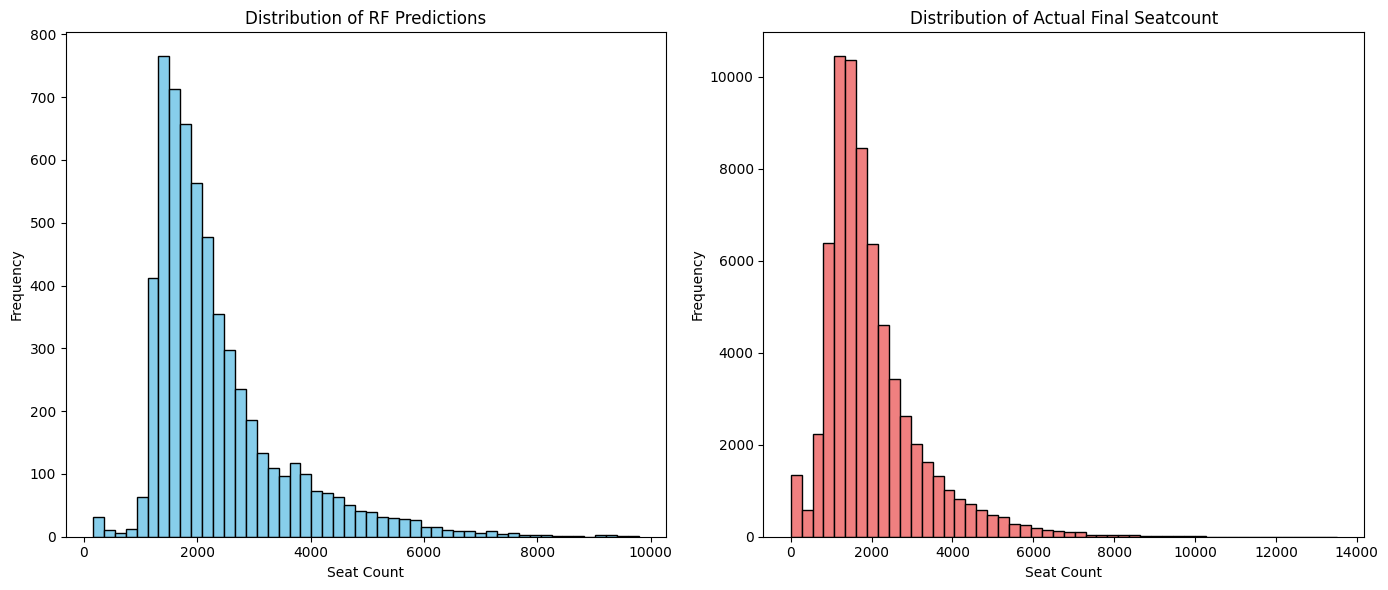

In [30]:
# Define the full list of features used
features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
                           'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
X_train_final = final_train_df[features_all]
y_train_final = final_train_df[target]

# Train the final model using ALL the data and best_params
final_model_rf = RandomForestRegressor(**best_params_rf)
final_model_rf.fit(X_train_final, y_train_final)

print("Final RF model trained on all data with all features.")

print("Making predictions with final models...")

rf_preds = final_model_rf.predict(X_test)

test_final['rf_preds'] = rf_preds

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a figure with 2 subplots (1 row, 2 columns)

rf_preds_series = pd.Series(rf_preds)

# Plot histogram for predictions on the first subplot
rf_preds_series.plot.hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of RF Predictions')
axes[0].set_xlabel('Seat Count')
axes[0].set_ylabel('Frequency')

# Plot histogram for actual values on the second subplot
processed_train_data['final_seatcount'].plot.hist(ax=axes[1], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Actual Final Seatcount')
axes[1].set_xlabel('Seat Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gb(trial):
    # Define the hyperparameter search space for this trial
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(processed_train_data):


        train_fold_df = processed_train_data.iloc[train_index].copy()
        val_fold_df = processed_train_data.iloc[val_index].copy()

        ### Create Route Average Demand
        route_demand_summary_overall = train_fold_df.groupby('route')[target].mean().rename('route_avg_demand_overall').reset_index()

        # Calculate rolling features of Route Average Demand
        train_fold_df.set_index('doj', inplace=True)
        train_fold_df = train_fold_df.assign(
            route_avg_demand_last_3m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('90D').mean()),
            route_avg_demand_last_6m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('180D').mean()),
            route_avg_demand_last_9m = train_fold_df.groupby('route')[target].transform(lambda x: x.shift(1).rolling('270D').mean())
        )

        # Bring 'doj' back to being a regular column
        train_fold_df.reset_index(inplace=True)

        # Create momentum feature
        epsilon = 1e-6 # To avoid division by zero
        train_fold_df['momentum_3m_vs_6m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_6m'] + epsilon)
        train_fold_df['momentum_6m_vs_9m'] = train_fold_df['route_avg_demand_last_6m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)
        train_fold_df['momentum_3m_vs_9m'] = train_fold_df['route_avg_demand_last_3m'] / (train_fold_df['route_avg_demand_last_9m'] + epsilon)

        train_fold_df = pd.merge(train_fold_df, route_demand_summary_overall, on='route', how='left')
        val_fold_df = pd.merge(val_fold_df, route_demand_summary_overall, on='route', how='left')

        # For rolling features, get the LAST calculated value for each route from the training data
        last_known_rolling_vals = train_fold_df.sort_values('doj').groupby('route').last()[[
            'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m'
        ]]
        val_fold_df = pd.merge(val_fold_df, last_known_rolling_vals, on='route', how='left')

        # Create Global Average Demand
        global_avg_demand = train_fold_df[target].mean()
        # Columns to fill with the global average
        fill_avg_cols = ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m']
        for col in fill_avg_cols:
            train_fold_df.fillna({col: global_avg_demand}, inplace=True)
            val_fold_df.fillna({col: global_avg_demand}, inplace=True)

        # For ratios, a neutral value is 1 (indicating no change)
        train_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        train_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)

        val_fold_df.fillna({'momentum_3m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_6m_vs_9m': 1}, inplace=True)
        val_fold_df.fillna({'momentum_3m_vs_6m': 1}, inplace=True)


        # Create Final Train and Validation Dataframe
        train_fold_final = train_fold_df.copy()
        val_fold_final = val_fold_df.copy()

        features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m', 'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
        X_train = train_fold_final[features_all]
        y_train = train_fold_final[target]
        X_val = val_fold_final[features_all]
        y_val = val_fold_final[target]

        model = GradientBoostingRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    # Return the average score for this set of hyperparameters
    return np.mean(rmse_scores)

study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True) # Run 50-100 trials

print("Number of finished trials: ", len(study_gb.trials))
print("Best trial:")
best_trial_gb = study_gb.best_trial

print("  Value (RMSE): ", best_trial_gb.value)
print("  Params: ")
for key, value in best_trial_gb.params.items():
    print(f"    {key}: {value}")

best_params_gb = study_gb.best_params

[I 2025-06-22 12:35:17,638] A new study created in memory with name: no-name-e256a1a9-33bc-4d66-a9df-4450b1a34069


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-22 12:36:00,959] Trial 0 finished with value: 557.1266287856935 and parameters: {'n_estimators': 369, 'learning_rate': 0.1289875738105557, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.534318563654432, 'max_features': 'log2'}. Best is trial 0 with value: 557.1266287856935.
[I 2025-06-22 12:36:54,129] Trial 1 finished with value: 553.8498741181379 and parameters: {'n_estimators': 261, 'learning_rate': 0.19078057782403338, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 6, 'subsample': 0.8429670564377366, 'max_features': 'log2'}. Best is trial 1 with value: 553.8498741181379.
[I 2025-06-22 12:38:49,754] Trial 2 finished with value: 638.9470523993764 and parameters: {'n_estimators': 166, 'learning_rate': 0.01932994207804426, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7321835008799977, 'max_features': None}. Best is trial 1 with value: 553.8498741181379.
[I 2025-06-22 12:40:42,333] Trial 3 finished w

Final GB model trained on all data with all features.
Making predictions with final models...


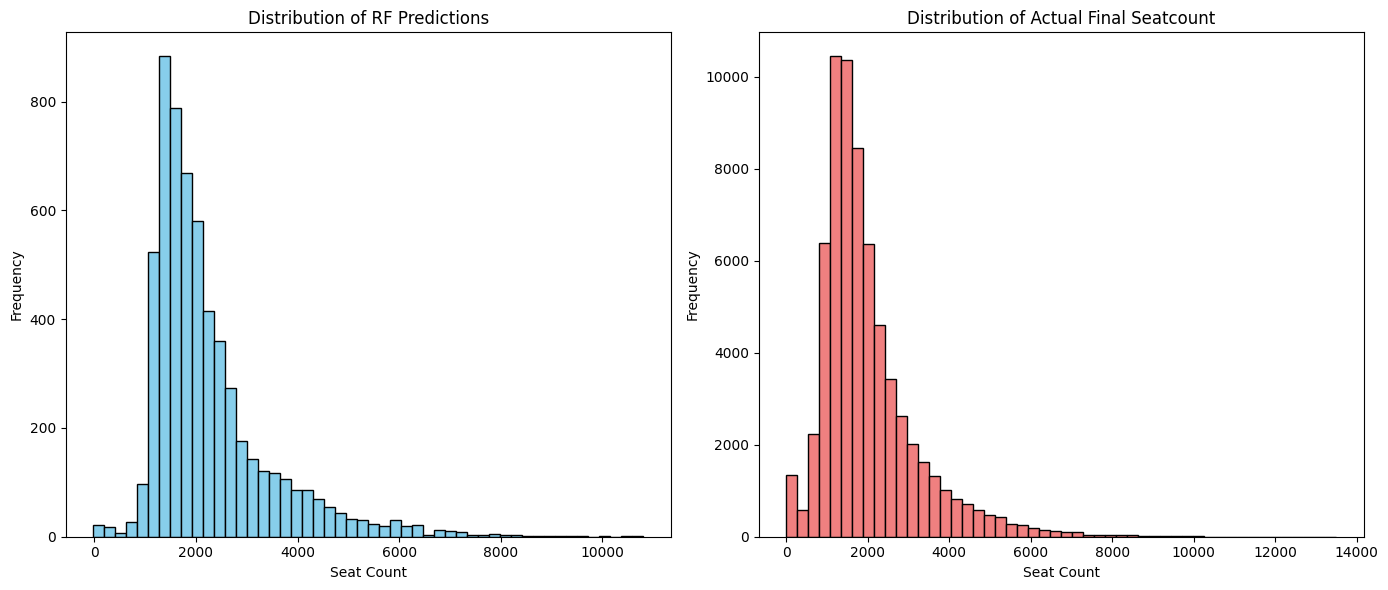

In [32]:
# Define the full list of features used
features_all = features + ['route_avg_demand_overall', 'route_avg_demand_last_3m', 'route_avg_demand_last_6m', 'route_avg_demand_last_9m',
                           'momentum_3m_vs_6m', 'momentum_6m_vs_9m', 'momentum_3m_vs_9m']
X_train_final = final_train_df[features_all]
y_train_final = final_train_df[target]

# Train the final model using ALL the data and best_params
final_model_gb = GradientBoostingRegressor(**best_params_gb)
final_model_gb.fit(X_train_final, y_train_final)

print("Final GB model trained on all data with all features.")

print("Making predictions with final models...")

gb_preds = final_model_gb.predict(X_test)

test_final['gb_preds'] = gb_preds

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a figure with 2 subplots (1 row, 2 columns)

gb_preds_series = pd.Series(gb_preds)

# Plot histogram for predictions on the first subplot
gb_preds_series.plot.hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of RF Predictions')
axes[0].set_xlabel('Seat Count')
axes[0].set_ylabel('Frequency')

# Plot histogram for actual values on the second subplot
processed_train_data['final_seatcount'].plot.hist(ax=axes[1], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Actual Final Seatcount')
axes[1].set_xlabel('Seat Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [33]:
# Calculate weights
inv_rmse_lgb = 1 / best_trial_lgbm.values[0]
inv_rmse_xgb = 1 / best_trial_xgb.values[0]
inv_rmse_rf = 1 / best_trial_rf.values[0]
inv_rmse_gb = 1 / best_trial_gb.values[0]
total_inv_rmse = inv_rmse_lgb + inv_rmse_xgb + inv_rmse_rf + inv_rmse_gb
w_lgb = inv_rmse_lgb / total_inv_rmse
w_xgb = inv_rmse_xgb / total_inv_rmse
w_rf = inv_rmse_rf / total_inv_rmse
w_gb = inv_rmse_gb / total_inv_rmse

print(f"Blending with weights -> LGBM: {w_lgb:.3f}, XGB: {w_xgb:.3f}, RF: {w_rf:.3f}, GB: {w_gb:.3f}")

# Combine the predictions
test_final['final_predictions'] = w_lgb * test_final['lgb_preds'] + w_xgb * test_final['xgb_preds'] + w_rf * test_final['rf_preds'] + w_gb * test_final['gb_preds']

# Post-processing: ensure no negative seat counts
test_final[test_final['final_predictions'] < 0] = 0

Blending with weights -> LGBM: 0.243, XGB: 0.257, RF: 0.241, GB: 0.259


In [34]:
test_final

,doj,srcid,destid,final_seatcount,is_train,route_key,route,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,doi_22,srcid_region_22,destid_region_22,srcid_tier_22,destid_tier_22,cumsum_seatcount_22,cumsum_searchcount_22,dbd_22,seats_booked_7_days_previous,seats_searched_7_days_previous,doj_day_of_month,doj_day_of_week,doj_month,doj_year,doj_week_of_year,doj_is_weekend,doj_is_holday,doj_is_long_weekend,doj_close_to_holiday,doj_custom_events,search_to_book_ratio,doj_custom_events_transformed,route_avg_demand_overall,route_avg_demand_last_3m,route_avg_demand_last_6m,route_avg_demand_last_9m,momentum_3m_vs_9m,momentum_3m_vs_6m,momentum_6m_vs_9m,lgb_preds,xgb_preds,rf_preds,gb_preds,final_predictions
672,2025-01-01,11,36,NaN,0,2025-01-01_11_36,11_36,2024-12-17,Rest of North,Delhi,1,2,32.0,1160.0,15,2024-12-10,Rest of North,Delhi,Tier 1,Tier2,28.0,628.0,22,4.0,532.0,1,2,1,2025,1,0,0,0,25,Peak_Wedding_Season,0.027586,2,2083.333333,2900.222222,2552.000000,2432.488889,1.192286,1.136451,1.049131,2243.067474,2339.800537,2212.928053,2246.703116,2261.572710
673,2025-01-02,11,36,NaN,0,2025-01-02_11_36,11_36,2024-12-18,Rest of North,Delhi,1,2,4.0,644.0,15,2024-12-11,Rest of North,Delhi,Tier 1,Tier2,0.0,428.0,22,4.0,216.0,2,3,1,2025,1,0,0,0,24,Peak_Wedding_Season,0.006211,2,2083.333333,2915.865169,2554.033520,2435.137546,1.197413,1.141671,1.048825,2108.659721,2183.116943,2100.986799,2048.722170,2110.383926
674,2025-01-03,11,36,NaN,0,2025-01-03_11_36,11_36,2024-12-19,Rest of North,Delhi,1,2,0.0,544.0,15,2024-12-12,Rest of North,Delhi,Tier 1,Tier2,0.0,336.0,22,0.0,208.0,3,4,1,2025,1,0,0,0,23,Peak_Wedding_Season,0.000000,2,2083.333333,2929.454545,2555.438202,2435.656716,1.202737,1.146361,1.049178,2302.089873,2279.793945,2187.778878,2090.219349,2213.881046
675,2025-01-04,11,36,NaN,0,2025-01-04_11_36,11_36,2024-12-20,Rest of North,Delhi,1,2,4.0,644.0,15,2024-12-13,Rest of North,Delhi,Tier 1,Tier2,4.0,380.0,22,0.0,264.0,4,5,1,2025,1,1,0,0,22,Peak_Wedding_Season,0.006211,2,2083.333333,2942.666667,2552.248588,2439.191011,1.206411,1.152970,1.046350,2383.977994,2392.937500,2492.953795,2315.351780,2394.763402
676,2025-01-05,11,36,NaN,0,2025-01-05_11_36,11_36,2024-12-21,Rest of North,Delhi,1,2,8.0,1348.0,15,2024-12-14,Rest of North,Delhi,Tier 1,Tier2,4.0,384.0,22,4.0,964.0,5,6,1,2025,1,1,0,0,21,Peak_Wedding_Season,0.005935,2,2083.333333,2938.372093,2553.522727,2444.962406,1.201807,1.150713,1.044402,3195.963008,3115.339111,2888.161716,3076.332920,3070.040427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2025-02-24,9,46,NaN,0,2025-02-24_09_46,9_46,2025-02-09,Tamil Nadu,Tamil Nadu,2,1,75.0,1959.0,15,2025-02-02,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,21.0,702.0,22,54.0,1257.0,24,0,2,2025,9,0,0,0,2,Off_Season,0.038285,1,4814.683036,5001.083333,5162.809524,5119.888889,0.976795,0.968675,1.008383,5030.210540,4953.454102,4594.092409,4788.947571,4842.810392
73096,2025-02-25,9,46,NaN,0,2025-02-25_09_46,9_46,2025-02-10,Tamil Nadu,Tamil Nadu,2,1,15.0,738.0,15,2025-02-03,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,0.0,228.0,22,15.0,510.0,25,1,2,2025,9,0,0,1,1,Off_Season,0.020325,1,4814.683036,5035.542857,5175.504000,5122.855814,0.982956,0.972957,1.010277,3539.983149,3666.410400,3646.636964,3395.261790,3560.634551
73097,2025-02-26,9,46,NaN,0,2025-02-26_09_46,9_46,2025-02-11,Tamil Nadu,Tamil Nadu,2,1,42.0,2127.0,15,2025-02-04,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,12.0,648.0,22,30.0,1479.0,26,2,2,2025,9,0,1,0,33,Off_Season,0.019746,1,4814.683036,5081.029412,5193.822581,5120.677570,0.992257,0.978283,1.014284,4395.819292,4345.455566,4252.867987,4097.513101,4271.093342
73098,2025-02-27,9,46,NaN,0,2025-02-27_09_46,9_46,2025-02-12,Tamil Nadu,Tamil Nadu,2,1,141.0,3360.0,15,2025-02-05,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,60.0,1353.0,22,81.0,2007.0,27,3,2,2025,9,0,0,1,32,Off_Season,0.041964,1,4814

In [35]:
final_submission = test_final[['route_key', 'final_predictions']].copy()
final_submission = final_submission.rename(columns={'final_predictions': 'final_seatcount'})
final_submission.head()

,route_key,final_seatcount
672,2025-01-01_11_36,2261.572710
673,2025-01-02_11_36,2110.383926
674,2025-01-03_11_36,2213.881046
675,2025-01-04_11_36,2394.763402
676,2025-01-05_11_36,3070.040427


In [36]:
final_submission.to_csv('submission.csv', index=False)

In [37]:
lgbm_submission = test_final[['route_key', 'lgb_preds']].copy()
lgbm_submission = lgbm_submission.rename(columns={'lgb_preds': 'final_seatcount'})
lgbm_submission.to_csv('lgbm_submission.csv', index=False)

xgb_submission = test_final[['route_key', 'xgb_preds']].copy()
xgb_submission = xgb_submission.rename(columns={'xgb_preds': 'final_seatcount'})
xgb_submission.to_csv('xgb_submission.csv', index=False)

rf_submission = test_final[['route_key', 'rf_preds']].copy()
rf_submission = rf_submission.rename(columns={'rf_preds': 'final_seatcount'})
rf_submission.to_csv('rf_submission.csv', index=False)

gb_submission = test_final[['route_key', 'gb_preds']].copy()
gb_submission = gb_submission.rename(columns={'gb_preds': 'final_seatcount'})
gb_submission.to_csv('gb_submission.csv', index=False)